## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
#from planning import a_star
from planning_ver2 import a_star


%matplotlib inline

#from bresenham import bresenham

In [148]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [149]:
?a_star

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [150]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [151]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [152]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

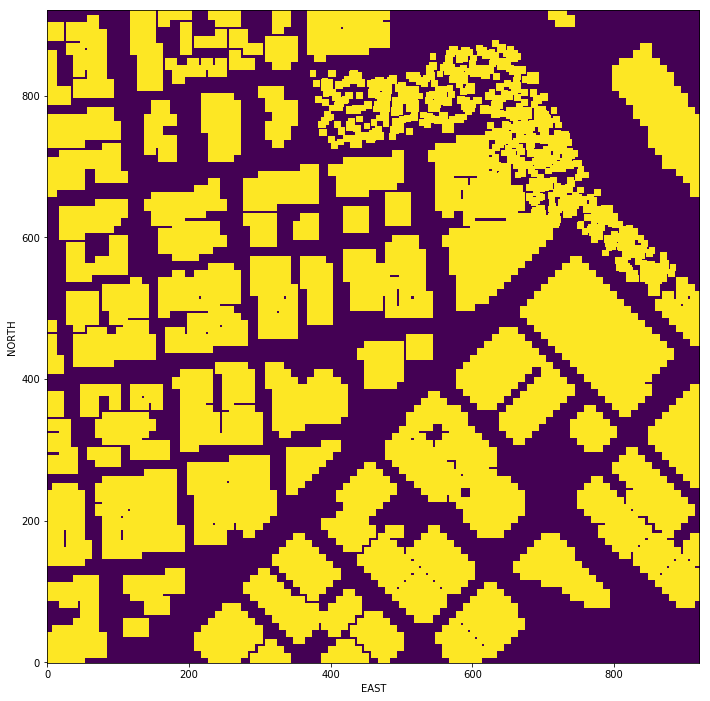

In [153]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [154]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [177]:
def heuristic(position, goal_position , method = 'Euclidean' ):
    # TODO: write a heuristic!    
    if method == 'Euclidean':
        h = ((position[0]-goal_position[0])**2 + (position[1]-goal_position[1])**2)**0.5
    elif method == 'Manhattan':
        h = abs(position[0]-goal_position[0]) + abs(position[1]-goal_position[1])
    else:
        print('Warning!!! Unknown method - {} \n return h=0 '.format(method))
        h = 0
            
    return h

In [178]:
?a_star

Compute the lowest cost path with `a_star`. 

In [179]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid,heuristic,start_ne,goal_ne)
print(len(path), cost)

Found a path.
786 898.4945160902303


Let's plot the path!

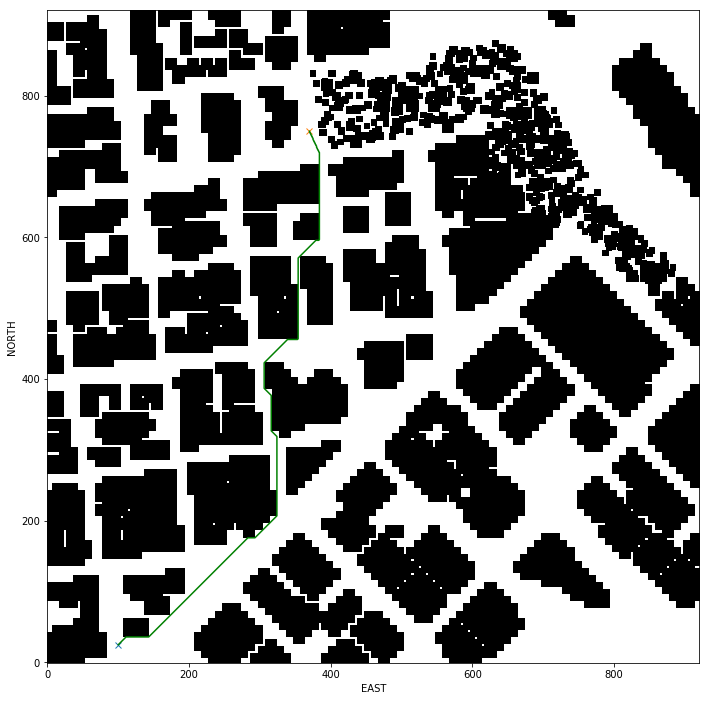

In [180]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [184]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=0.1):   
    m = np.concatenate((p1, p2, p3), 0)
    #print('p1 \n', p1)
    #print('p2 \n',p2)
    #print('p3 \n',p3)
    #print('m \n',m)
    det = np.linalg.det(m)
    #if det >= epsilon:
        #print('det \n',det)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [185]:
def prune_path(path):
    if path is not None:
        pruned_path = [p for p in path]
        # TODO: prune the path!
        if len(pruned_path) >=3:
            redundant_points = [False]
            for i in range(1,len(pruned_path)-2):
                redundant_points.append(collinearity_check(point(path[i-1]),point(path[i]),point(path[i+1])))
            redundant_points.append(False)
        pruned_path = [ p for p,redundant in zip(pruned_path,redundant_points) if not redundant] 
    else:
        pruned_path = path
    return pruned_path

Prune the path.

In [186]:
pruned_path = prune_path(path)
print(len(pruned_path))

46


In [187]:
pruned_path

[(25, 100),
 (36, 111),
 (36, 143),
 (176, 283),
 (176, 293),
 (207, 324),
 (319, 324),
 (327, 316),
 (377, 316),
 (387, 306),
 (423, 306),
 (456, 339),
 (456, 353),
 (457, 354),
 (571, 354),
 (596, 379),
 (596, 383),
 (597, 384),
 (720, 384),
 (721, 383),
 (722, 383),
 (723, 382),
 (724, 382),
 (725, 381),
 (726, 381),
 (727, 380),
 (729, 380),
 (730, 379),
 (731, 379),
 (732, 378),
 (733, 378),
 (734, 377),
 (735, 377),
 (736, 376),
 (737, 376),
 (738, 375),
 (740, 375),
 (741, 374),
 (742, 374),
 (743, 373),
 (744, 373),
 (745, 372),
 (746, 372),
 (747, 371),
 (748, 371),
 (749, 370)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

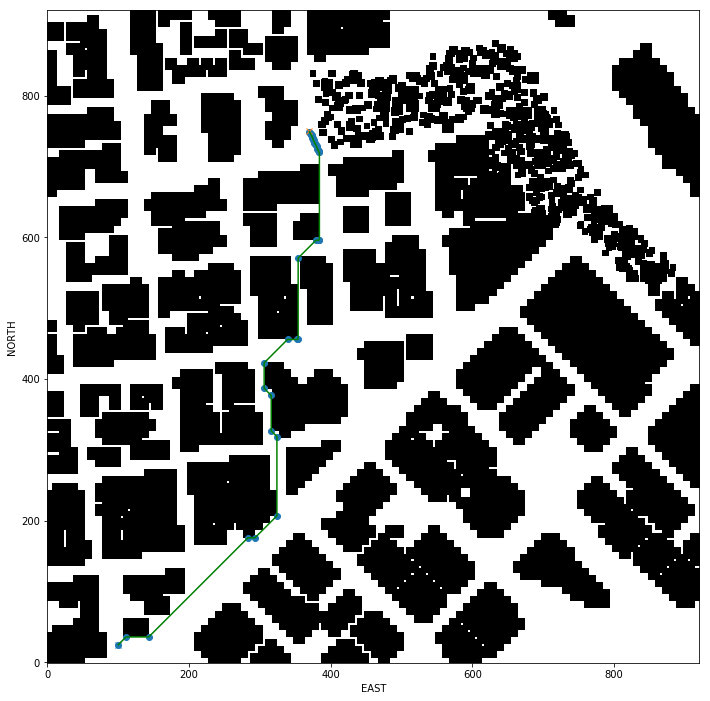

In [188]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

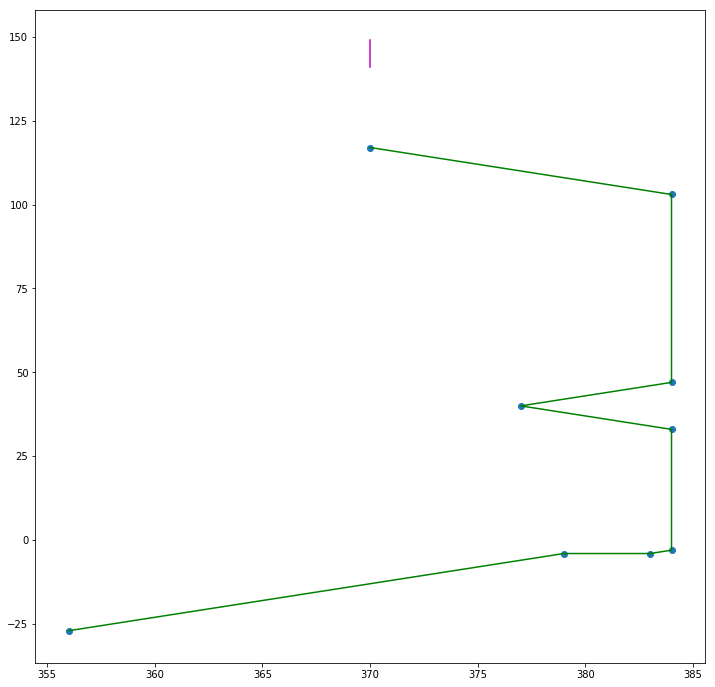

In [175]:
if pruned_path is not None:
    pp = np.array(pruned_path)
    ppp = np.array(path)
    plt.plot(pp[-10:-1, 1], pp[-10:-1, 0]-600, 'g')
    plt.scatter(pp[-10:-1, 1], pp[-10:-1, 0]-600)
    plt.plot(ppp[-10:-1, 1], ppp[-10:-1, 0]-600, 'm')